# Pk Emulator

## PCA+InterPol Method

In [1]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from sklearn.decomposition import PCA

class Lin_Pk_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_evecs
        self.k_arr = np.logspace(-4.7,5, n_k)
        self.wc_arr  = np.linspace(0.1, 1, n_train)
        self.h_arr  = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self._get_theory_Pk(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
                
            np.savetxt('Pk_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('Pk_grid.txt')
        
        self.log_grid = np.log(self.grid)
        self.mean_log_grid = np.mean(np.log(self.grid), axis=0) #avg over all cosmologies
        self.clean_grid = self.log_grid - self.mean_log_grid
        
        self.evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        
        return 
            
    
    def get_evecs(self):
        if self.evecs is None:
            pca = PCA(n_components=self.n_evecs)
            self.evecs = pca.fit_transform(np.transpose(self.clean_grid))
            w1 = np.array(np.ones(len(self.k_arr)))
            self.evecs = np.insert(np.transpose(self.evecs), 0, [w1], axis=0)
            self.evecs = np.transpose(self.evecs)
        return self.evecs
    
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    Pk_ij = self._get_theory_Pk(self.wc_arr[i], self.h_arr[j])
                    w_ij = self._get_weigths(Pk_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w =0
            for grid in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, grid, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, Pk):
        y = np.log(Pk) - self.mean_log_grid
        return np.linalg.lstsq(self.evecs, y, rcond=None)[0]
        
    def _get_theory_Pk(self, wc, h):
        cosmo = ccl.Cosmology(Omega_c=wc, Omega_b=0.049, h=h, sigma8=0.81, n_s=0.96)
        return ccl.power.linear_matter_power(cosmo, self.k_arr, 1)
        
    def _get_evec_Pk(self, weigths , evecs, mean):
        print(evecs.shape)
        print(weigths.shape)
        return mean + np.sum(evecs*weigths, axis=1) 
    
    def get_emulated_Pk(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(self.n_evecs+1):
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        Pk = self._get_evec_Pk(w_vec, self.evecs, self.mean_log_grid)
        return self.k_arr, np.array(Pk)
    
    

In [2]:
test = Lin_Pk_emulator(10, 10, 10, new= True)

In [3]:
test.get_evecs();

In [4]:
w_arr = test.get_w_arr()

In [5]:
test.get_w_emulator()

{'w_0': <scipy.interpolate.interpolate.interp2d at 0x7f86b4675cd0>,
 'w_1': <scipy.interpolate.interpolate.interp2d at 0x7f86b4675670>,
 'w_2': <scipy.interpolate.interpolate.interp2d at 0x7f86b46754f0>,
 'w_3': <scipy.interpolate.interpolate.interp2d at 0x7f86b4675790>,
 'w_4': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ed4fd0>,
 'w_5': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef1310>,
 'w_6': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef13a0>,
 'w_7': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef1190>,
 'w_8': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef1b50>,
 'w_9': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef1100>,
 'w_10': <scipy.interpolate.interpolate.interp2d at 0x7f86b4ef18e0>}

In [6]:
k_arr, emulated = test.get_emulated_Pk(0.3,0.9 )

(10, 11)
(11,)


In [7]:
cosmo = ccl.Cosmology(Omega_c=0.3, Omega_b=0.049, h=0.9, sigma8=0.81, n_s=0.96)
theory  = ccl.power.linear_matter_power(cosmo, k_arr, 1)

In [8]:
emulated = np.exp(emulated)

In [9]:
Pk_diff = abs(emulated-theory)

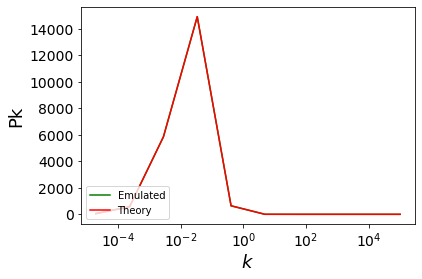

In [10]:
plt.plot(k_arr, emulated , 'g-', label = 'Emulated' )
plt.plot(k_arr, theory, 'r-', label = 'Theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Pk',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

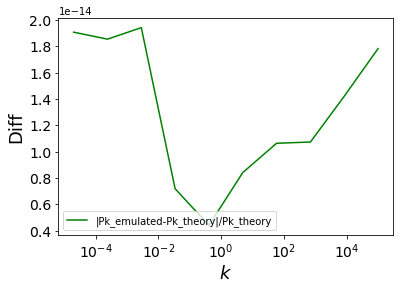

In [11]:
plt.plot(k_arr, Pk_diff/theory, 'g-', label = '|Pk_emulated-Pk_theory|/Pk_theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

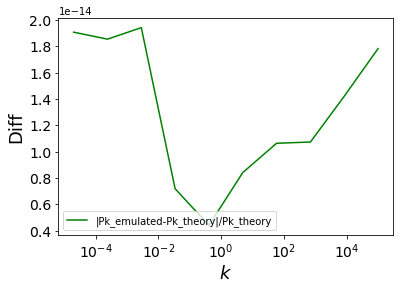

In [12]:
plt.plot(k_arr, Pk_diff/theory, 'g-', label = '|Pk_emulated-Pk_theory|/Pk_theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

# Toy Model

In [13]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg as LA
from sklearn.decomposition import PCA

class Toy_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_k #Complete space
        self.k_arr   = np.linspace(0,100, n_k)
        self.k_mean  = np.mean(self.k_arr)
        self.wc_arr  = np.linspace(0.25, 0.3, n_train)
        self.h_arr   = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self.get_theory(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
            np.savetxt('toy_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('toy_grid.txt')
        
        self.grid_mean = np.mean(self.grid, axis=0)
        self.residues = self.grid-self.grid_mean
        self.evecs = None
        self.hand_evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        return 
            
    
    def get_evecs(self):
        if self.evecs is None:
            pca = PCA(n_components=self.n_evecs) 
            self.evecs = pca.fit_transform(np.transpose(self.residues))
            w1 = np.array(np.ones(len(self.k_arr)))
            self.evecs = np.insert(np.transpose(self.evecs), 0, [w1], axis=0)
            self.evecs = np.transpose(self.evecs)
        return self.evecs
       
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    f_k_ij = self.get_theory(self.wc_arr[i], self.h_arr[j]) - self.grid_mean
                    w_ij = self._get_weigths(f_k_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w = 0
            for w_i in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, w_i, kind='cubic')
                                                #interp2d( x(column coor), y(row coor), w_i, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, target):
        return np.linalg.lstsq(self.evecs, target, rcond=None)[0]
        
    def get_theory(self, wc, h):
        return h + wc*(self.k_arr-self.k_mean/2)
        
    def _get_predict(self, weigths , evecs):
        return self.grid_mean + np.sum(evecs*weigths, axis=1) 
    
    def get_emulated_f(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(self.n_evecs+1): # n_evecs
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        f_k = self._get_predict(w_vec, self.evecs)
        return self.k_arr, np.array(f_k)
    
    

In [14]:
toy = Toy_emulator(10, 10, None, new= True)

In [15]:
evecs = np.transpose(toy.get_evecs())
print(evecs.shape)
print(evecs)

(11, 10)
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-7.97855923e+00 -6.20554607e+00 -4.43253291e+00 -2.65951974e+00
  -8.86506581e-01  8.86506581e-01  2.65951974e+00  4.43253291e+00
   6.20554607e+00  7.97855923e+00]
 [ 5.50787293e-15  2.37621242e-14  3.23470312e-16 -3.70265975e-15
   5.65192678e-16 -3.23300190e-14 -2.98728603e-14  2.42087947e-14
  -4.57223568e-14  5.86601572e-14]
 [ 2.61415257e-15  1.52932566e-15  6.55914660e-16 -2.54745446e-16
  -1.82219551e-15 -3.70837830e-15 -3.82987477e-15 -7.21728807e-15
   7.36033592e-15  3.85420952e-15]
 [ 8.24535028e-16  5.49293692e-16  6.50991926e-17 -3.93747008e-16
  -8.04428637e-16 -2.94613196e-15 -3.47540946e-15  5.76195807e-15
   3.49401012e-15 -3.36553372e-15]
 [ 3.69280843e-16 -7.84800234e-16 -4.79268481e-16 -1.51493839e-16
  -3.79200039e-16  5.02921414e-15 -4.73073531e-15  6.46238730e-17
  -1.50117485e-16  4.989

In [16]:
w_arr = toy.get_w_arr()
print(w_arr.shape)
print(w_arr)

(11, 10, 10)
[[[-7.75000000e-01 -6.36111111e-01 -4.97222222e-01 ...  1.97222222e-01
    3.36111111e-01  4.75000000e-01]
  [-7.41666667e-01 -6.02777778e-01 -4.63888889e-01 ...  2.30555556e-01
    3.69444444e-01  5.08333333e-01]
  [-7.08333333e-01 -5.69444444e-01 -4.30555556e-01 ...  2.63888889e-01
    4.02777778e-01  5.41666667e-01]
  ...
  [-5.41666667e-01 -4.02777778e-01 -2.63888889e-01 ...  4.30555556e-01
    5.69444444e-01  7.08333333e-01]
  [-5.08333333e-01 -3.69444444e-01 -2.30555556e-01 ...  4.63888889e-01
    6.02777778e-01  7.41666667e-01]
  [-4.75000000e-01 -3.36111111e-01 -1.97222222e-01 ...  4.97222222e-01
    6.36111111e-01  7.75000000e-01]]

 [[-1.56669890e-01 -1.21854359e-01 -8.70388280e-02 ...  8.70388280e-02
    1.21854359e-01  1.56669890e-01]
  [-1.56669890e-01 -1.21854359e-01 -8.70388280e-02 ...  8.70388280e-02
    1.21854359e-01  1.56669890e-01]
  [-1.56669890e-01 -1.21854359e-01 -8.70388280e-02 ...  8.70388280e-02
    1.21854359e-01  1.56669890e-01]
  ...
  [-1.5666

In [17]:
toy.get_w_emulator()

{'w_0': <scipy.interpolate.interpolate.interp2d at 0x7f86312618b0>,
 'w_1': <scipy.interpolate.interpolate.interp2d at 0x7f86312615e0>,
 'w_2': <scipy.interpolate.interpolate.interp2d at 0x7f8631261580>,
 'w_3': <scipy.interpolate.interpolate.interp2d at 0x7f8631261790>,
 'w_4': <scipy.interpolate.interpolate.interp2d at 0x7f86312611c0>,
 'w_5': <scipy.interpolate.interpolate.interp2d at 0x7f8631261e20>,
 'w_6': <scipy.interpolate.interpolate.interp2d at 0x7f8631261e50>,
 'w_7': <scipy.interpolate.interpolate.interp2d at 0x7f8631261340>,
 'w_8': <scipy.interpolate.interpolate.interp2d at 0x7f8631261250>,
 'w_9': <scipy.interpolate.interpolate.interp2d at 0x7f8631261070>,
 'w_10': <scipy.interpolate.interpolate.interp2d at 0x7f8631261a90>}

In [24]:
k_arr, emulated = toy.get_emulated_f(0.27,0.67 )
theory = toy.get_theory(0.27, 0.67)

In [25]:
len(emulated)

10

In [26]:
theory

array([-6.08, -3.08, -0.08,  2.92,  5.92,  8.92, 11.92, 14.92, 17.92,
       20.92])

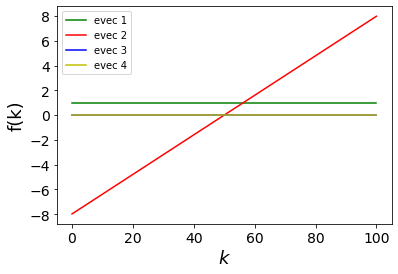

In [27]:
plt.plot( k_arr, evecs[0] , 'g-', label = 'evec 1' )
plt.plot( k_arr, evecs[1] , 'r-', label = 'evec 2' )
plt.plot( k_arr, evecs[2] , 'b-', label = 'evec 3' )
plt.plot( k_arr, evecs[3] , 'y-', label = 'evec 4' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

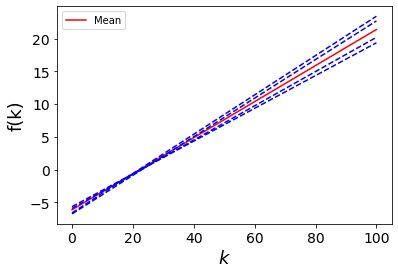

In [28]:
plt.plot( k_arr, toy.grid_mean*np.ones(len(k_arr)) , 'r-', label = 'Mean' )
plt.plot( k_arr, toy.grid[0] , 'b--' )
plt.plot( k_arr, toy.grid[20] , 'b--' )
plt.plot( k_arr, toy.grid[-20] , 'b--' )
plt.plot( k_arr, toy.grid[-1] , 'b--' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

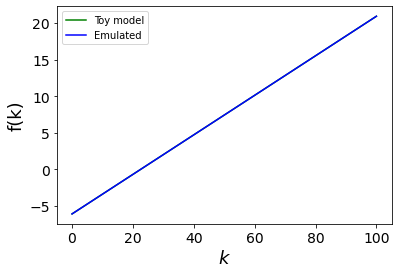

In [29]:
plt.plot(k_arr, theory , 'g-', label = 'Toy model' )
plt.plot(k_arr, emulated , 'b-', label = 'Emulated' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()